# Basketball Win Prediction: Models with ANOVA feature filtering for feature selection

The notebook evaluates 8 different model types across the Anova Top 30 feature selection set(features selected based on ANOVA F-score):
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Gradient Boosting
- LightGBM
- KMeans Clustering
- Neural Networks(PyTorch)

In [99]:
# Import all required packages for modeling, evaluation, preprocessing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, roc_curve, auc
)
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from scipy.stats import mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
# Create output directory
output_dir = Path("model_results/anova_top_30")
output_dir.mkdir(exist_ok=True, parents=True)
figures_dir = Path("figures/model_results/anova_top_30")
figures_dir.mkdir(exist_ok=True, parents=True)

## Load and prepare dataset
We start by loading the dataset containing engineered features and defining the target and feature matrix. Leakage columns are removed.

In [100]:
data_path = Path("engineered_data/engineered_final_feature_dataset.csv")
df = pd.read_csv(data_path)
X_full = df.drop(columns=["HOME_TEAM_WINS", "GAME_ID", "SEASON", "HOME_TEAM_ID", "VISITOR_TEAM_ID"])
print(X_full.columns)
y = df["HOME_TEAM_WINS"]
print(f"Loaded data with shape: {df.shape}")

Index(['GAME_DATE_EST', 'TEAM_ID_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'GAME_INDEX',
       'HOME_LAST_N_WIN_PCT', 'AWAY_LAST_N_WIN_PCT', 'HOME_LAST_N_AVG_PTS',
       'AWAY_LAST_N_AVG_PTS', 'HOME_LAST_N_AVG_PTS_ALLOWED',
       'AWAY_LAST_N_AVG_PTS_ALLOWED', 'TEAM_NAME_HOME', 'TOTAL_GAMES_HOME',
       'WINS_HOME', 'LOSSES_HOME', 'WIN_PCT_HOME', 'HOME_WINS_HOME',
       'HOME_LOSSES_HOME', 'AWAY_WINS_HOME', 'AWAY_LOSSES_HOME',
       'AVG_PTS_SCORED_HOME', 'AVG_PTS_CONCEDED_HOME', 'AVG_FG_PCT_HOME',
       'MAX_WIN_STREAK_HOME', 'MAX_LOSS_STREAK_HOME', 'TEAM_NAME_AWAY',
       'TOTAL_GAMES_AWAY', 'WINS_AWAY', 'LOSSES_AWAY', 'WIN_PCT_AWAY',
       'HOME_WINS_AWAY', 'HOME_LOSSES_AWAY', 'AWAY_WINS_AWAY',
       'AWAY_LOSSES_AWAY', 'AVG_PTS_SCORED_AWAY', 'AVG_PTS_CONCEDED_AWAY',
       'AVG_FG_PCT_AWAY', 'MAX_WIN_STREAK_AWAY', 'MAX_LOSS_STREAK_AWAY',
 

## Loading data
Feature data is loaded in, filtered for the top 30 ANOVA filtered features, and ANOVA-filtered features are scaled for use in models that require standardization.

In [101]:
# Load feature sets
feature_sets_path = Path("selected_features/feature_sets.pkl")
with open(feature_sets_path, "rb") as f:
    feature_sets = pickle.load(f)

recursive_feature = feature_sets['anova_top_30']

In [102]:
# Safely drop leakage columns that exist
leakage_columns = ['POINT_DIFF', 'ABS_POINT_DIFF', 'GAME_ID', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']
leakage_columns = [col for col in leakage_columns if col in df.columns]

X_full = df.drop(columns=leakage_columns + ['HOME_TEAM_WINS'])
y = df['HOME_TEAM_WINS']

print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")

Target distribution: {1.0: 0.5885332719318443, 0.0: 0.41146672806815565}


In [103]:
# Select ANOVA-Filtered features
selected_features = feature_sets['anova_top_30']
X = X_full[selected_features]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Imputation and Scaling
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=selected_features)
X_test = pd.DataFrame(imputer.transform(X_test), columns=selected_features)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)

## Define and configure models
We define all ML models, specifying whether they require scaling.

In [104]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05,
                                 use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1)
}

In [105]:
model_preds = {}
results = []
# Loop through each model and train it
# Collect performance metrics: accuracy, F1, AUC
for name, model in models.items():
    print(f"Training {name}...")

    X_train_input = X_train_scaled if name == "Logistic Regression" else X_train
    X_test_input = X_test_scaled if name == "Logistic Regression" else X_test
    model_preds[name] = {
    "y_true": y_test,
    "probas": probas
    }

    start = time.time()
    model.fit(X_train_input, y_train)
    duration = time.time() - start

    preds = model.predict(X_test_input)
    probas = model.predict_proba(X_test_input)[:, 1]

    results.append({
        "model_name": name,
        "accuracy": accuracy_score(y_test, preds),
        "f1_score": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probas),
        "train_time": duration
    })


Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training Gradient Boosting...
Training LightGBM...


In [106]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [107]:
# First dense layer with ReLU + BatchNorm + Dropout
class AdvancedNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedNet, self).__init__()
        self.dropout_input = nn.Dropout(0.1)

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout_input(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.output(x))

model = AdvancedNet(input_dim=X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [108]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 40

# Train
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f}")
training_time = time.time() - start_time


Epoch 1/40 | Loss: 128.3955
Epoch 2/40 | Loss: 124.2106
Epoch 3/40 | Loss: 121.7207
Epoch 4/40 | Loss: 120.8013
Epoch 5/40 | Loss: 121.4529
Epoch 6/40 | Loss: 121.3897
Epoch 7/40 | Loss: 119.8261
Epoch 8/40 | Loss: 120.4276
Epoch 9/40 | Loss: 119.9969
Epoch 10/40 | Loss: 120.4805
Epoch 11/40 | Loss: 120.3633
Epoch 12/40 | Loss: 119.9098
Epoch 13/40 | Loss: 119.2923
Epoch 14/40 | Loss: 119.7253
Epoch 15/40 | Loss: 118.8050
Epoch 16/40 | Loss: 119.9380
Epoch 17/40 | Loss: 119.4013
Epoch 18/40 | Loss: 118.8662
Epoch 19/40 | Loss: 119.0336
Epoch 20/40 | Loss: 119.2365
Epoch 21/40 | Loss: 118.7314
Epoch 22/40 | Loss: 118.5887
Epoch 23/40 | Loss: 119.1750
Epoch 24/40 | Loss: 119.3256
Epoch 25/40 | Loss: 118.3192
Epoch 26/40 | Loss: 119.0830
Epoch 27/40 | Loss: 118.6759
Epoch 28/40 | Loss: 118.1180
Epoch 29/40 | Loss: 117.5647
Epoch 30/40 | Loss: 118.0596
Epoch 31/40 | Loss: 118.7541
Epoch 32/40 | Loss: 118.2229
Epoch 33/40 | Loss: 117.6569
Epoch 34/40 | Loss: 118.0306
Epoch 35/40 | Loss: 118

In [109]:
# Evaluate PyTorch model on test data
model.eval()
with torch.no_grad():
    y_probs = model(X_test_tensor).numpy().flatten()
    y_preds = (y_probs >= 0.5).astype(int)

print("PyTorch Neural Network (ANOVA_Top_30 Features):")
print("Accuracy:", accuracy_score(y_test, y_preds))
print("F1 Score:", f1_score(y_test, y_preds))
print("AUC:", roc_auc_score(y_test, y_probs))

# Save to all_results
nn_result = {
    "model_name": "Neural Network (PyTorch)",
    "feature_set": "anova_top_30",
    "accuracy": accuracy_score(y_test, y_preds),
    "f1_score": f1_score(y_test, y_preds),
    "auc": roc_auc_score(y_test, y_probs),
    "train_time": training_time,
}

results.append(nn_result)

PyTorch Neural Network (ANOVA_Top_30 Features):
Accuracy: 0.8348042977743668
F1 Score: 0.8620855358000962
AUC: 0.9165843937607876


## KMeans Clustering Baseline
This is a clustering model for unsupervised learning. We align cluster labels using majority voting to match the target labels.

In [110]:
def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask], keepdims=True)[0]
    return labels

start = time.time()
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)
kmeans_preds = kmeans.predict(X_test_scaled)
aligned_preds = align_clusters(y_test.values, kmeans_preds)
train_time = time.time() - start

kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': accuracy_score(y_test, aligned_preds),
    'f1_score': f1_score(y_test, aligned_preds),
    'auc': roc_auc_score(y_test, aligned_preds),
    'train_time': train_time,
}

results.append(kmeans_result)

## Evaluation Results (Initial)
We display the performance of each model trained using the ANOVA filter feature set.

In [111]:
results_df = pd.DataFrame(results).sort_values("f1_score", ascending=False)
results_df.to_csv(output_dir / "ANOVA_results.csv", index=False)
results_df[['model_name', 'accuracy', 'f1_score', 'auc', 'train_time']].sort_values(
    by='f1_score', ascending=False
).reset_index(drop=True)

,model_name,accuracy,f1_score,auc,train_time
0,Neural Network (PyTorch),0.834804,0.862086,0.916584,54.782758
1,Logistic Regression,0.834037,0.860191,0.917954,0.268884
2,LightGBM,0.832694,0.858625,0.914826,0.338354
3,Gradient Boosting,0.832310,0.858347,0.913568,54.596862
4,XGBoost,0.828473,0.855340,0.912972,2.762100
5,Random Forest,0.827322,0.854792,0.909917,15.881361
6,Decision Tree,0.788757,0.820713,0.833231,0.432067
7,KMeans Clustering,0.651573,0.649556,0.673673,0.088998


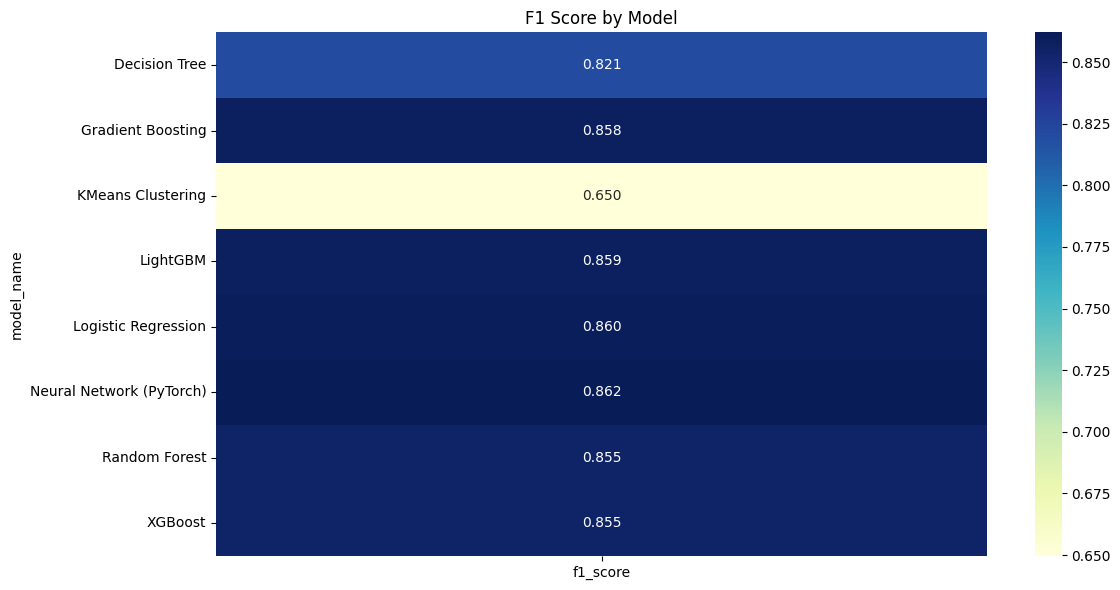

In [112]:
pivot_f1 = results_df.pivot_table(
    index='model_name', 
    values='f1_score'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("F1 Score by Model")
plt.tight_layout()
plt.show()

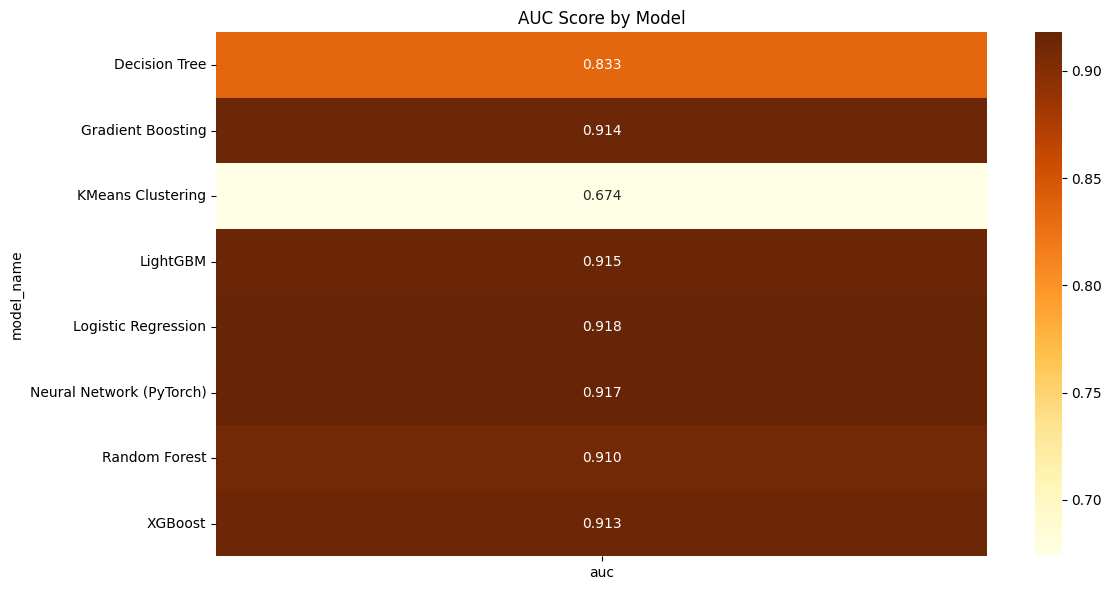

In [113]:
pivot_auc = results_df.pivot_table(
    index='model_name', 
    values='auc'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_auc, annot=True, fmt=".3f", cmap="YlOrBr")
plt.title("AUC Score by Model")
plt.tight_layout()
plt.show()


## Cross Validation (Sklearn Models)
We now evaluate models using 5-fold Stratified Cross-Validation.


In [114]:
# Evaluate accuracy, F1, and AUC for each model using cross_validate
def evaluate_model_cv(model, X, y, name, scale=False):
    if scale:
        X = StandardScaler().fit_transform(X)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, scoring=['accuracy', 'f1', 'roc_auc'], cv=cv)
    return {
        'model_name': name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1'])
    }

In [115]:
results_cv = []

for name, model in models.items():
    print(f"Running CV for: {name}")
    result = evaluate_model_cv(model, X, y, name)
    results_cv.append(result)

Running CV for: Logistic Regression
Running CV for: Decision Tree
Running CV for: Random Forest
Running CV for: XGBoost
Running CV for: Gradient Boosting
Running CV for: LightGBM


## PyTorch Neural Net + KMeans Clustering: Cross Validation
We train a new neural network per fold, and collect performance metrics, and label alignment is performed for each fold as well.

In [116]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KMeans Clustering CV Evaluation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        # Get scalar mode value only
        majority_label = mode(y_true[mask], keepdims=True).mode[0]
        labels[mask] = majority_label
    return labels

kmeans_metrics = {'accuracy': [], 'f1_score': [], 'auc': []}

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    kmeans.fit(X_train_fold)
    preds = kmeans.predict(X_test_fold)
    aligned_preds = align_clusters(y_test_fold, preds)

    kmeans_metrics['accuracy'].append(accuracy_score(y_test_fold, aligned_preds))
    kmeans_metrics['f1_score'].append(f1_score(y_test_fold, aligned_preds))
    kmeans_metrics['auc'].append(roc_auc_score(y_test_fold, aligned_preds))

print("\nKMeans Clustering Cross-Validation:")
print(f"Accuracy: {np.mean(kmeans_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(kmeans_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(kmeans_metrics['auc']):.4f}")

# Neural Network CV (PyTorch)

for train_idx, test_idx in cv.split(X_scaled, y):
    # Prepare tensors
    X_train_fold = torch.tensor(X_scaled[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y.values[train_idx], dtype=torch.float32).view(-1, 1)
    X_test_fold = torch.tensor(X_scaled[test_idx], dtype=torch.float32)
    y_test_fold = torch.tensor(y.values[test_idx], dtype=torch.float32).view(-1, 1)

    # Dataloader for mini-batch training
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Model
    model = AdvancedNet(input_dim=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Optional: learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training loop
    for epoch in range(30):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        probs = model(X_test_fold).numpy().flatten()
        preds = (probs >= 0.5).astype(int)
        y_true = y_test_fold.numpy().flatten()

        nn_metrics['accuracy'].append(accuracy_score(y_true, preds))
        nn_metrics['f1_score'].append(f1_score(y_true, preds))
        nn_metrics['auc'].append(roc_auc_score(y_true, probs))

# Final CV results
print("\nNeural Network (AdvancedNet) Cross-Validation:")
print(f"Accuracy: {np.mean(nn_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(nn_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(nn_metrics['auc']):.4f}")


KMeans Clustering Cross-Validation:
Accuracy: 0.6579
F1 Score: 0.6598
AUC: 0.6782

Neural Network (AdvancedNet) Cross-Validation:
Accuracy: 0.8254
F1 Score: 0.8544
AUC: 0.9077


## Cross-Validation Heatmaps
Heatmaps provide a quick overview of model performance across F1 and AUC.


In [117]:
traditional_df = pd.DataFrame(results_cv)

# KMeans results
kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': np.mean(kmeans_metrics['accuracy']),
    'f1_score': np.mean(kmeans_metrics['f1_score']),
    'auc': np.mean(kmeans_metrics['auc']),
    'cv_std': np.std(kmeans_metrics['f1_score'])
}

# PyTorch NN results
nn_result = {
    'model_name': 'Neural Network (PyTorch)',
    'accuracy': np.mean(nn_metrics['accuracy']),
    'f1_score': np.mean(nn_metrics['f1_score']),
    'auc': np.mean(nn_metrics['auc']),
    'cv_std': np.std(nn_metrics['f1_score'])
}

# Combine all results
all_cv_results = pd.concat([traditional_df, pd.DataFrame([kmeans_result, nn_result])], ignore_index=True)

# Sort by F1 Score
all_cv_results = all_cv_results.sort_values(by='f1_score', ascending=False)

# Display table
print(all_cv_results[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std']]) 

                 model_name  accuracy  f1_score       auc    cv_std
0       Logistic Regression  0.837516  0.863492  0.919504  0.002429
5                  LightGBM  0.835674  0.861348  0.917704  0.002053
4         Gradient Boosting  0.834293  0.860031  0.916176  0.003413
3                   XGBoost  0.833564  0.859951  0.916861  0.002767
2             Random Forest  0.829419  0.856691  0.912013  0.002029
7  Neural Network (PyTorch)  0.825390  0.854414  0.907719  0.013607
1             Decision Tree  0.792616  0.824728  0.833335  0.004575
6         KMeans Clustering  0.657917  0.659812  0.678188  0.007135


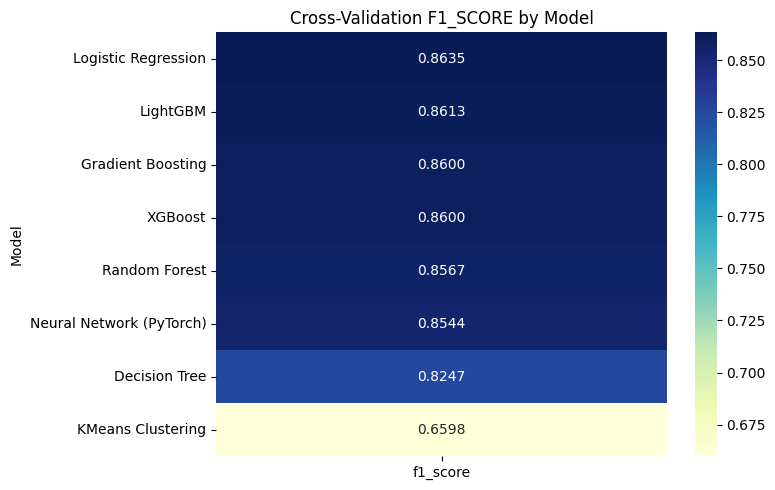

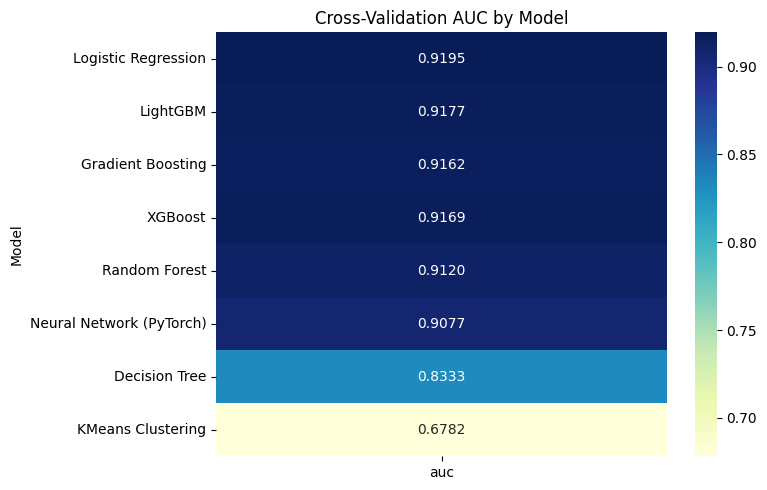

In [118]:
metrics_to_plot = ['f1_score', 'auc']

for metric in metrics_to_plot:
    pivot_df = all_cv_results[['model_name', metric]].set_index('model_name')
    
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".4f", cbar=True)
    plt.title(f"Cross-Validation {metric.upper()} by Model")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

## HyperParameter Tuning
To push model performance, we perform GridSearchCV with cross-validation to find the best params for each model, with tuning being done with F1 as scoring.

In [119]:
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'verbose': [-1]
        }
    }
}

In [120]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_results = []

for name, cfg in param_grids.items():
    print(f"\nRunning GridSearchCV for: {name}")
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=cv, scoring='f1', n_jobs=-1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    scores = grid.cv_results_

    tuned_results.append({
        'model_name': name,
        'best_params': grid.best_params_,
        'mean_accuracy': np.mean(scores['mean_test_score']),
        'best_score': grid.best_score_
    })
    
tuned_df = pd.DataFrame(tuned_results)
tuned_df = tuned_df.sort_values(by='best_score', ascending=False)


Running GridSearchCV for: Logistic Regression

Running GridSearchCV for: Random Forest

Running GridSearchCV for: Gradient Boosting

Running GridSearchCV for: XGBoost

Running GridSearchCV for: LightGBM


In [121]:
print(tuned_df[['model_name', 'best_params', 'best_score']])

            model_name                                        best_params  \
0  Logistic Regression      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}   
3              XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
4             LightGBM  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
2    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
1        Random Forest  {'max_depth': None, 'min_samples_split': 5, 'n...   

   best_score  
0    0.863634  
3    0.862816  
4    0.861936  
2    0.861911  
1    0.858105  


In [ ]:
final_tuned_cv_results = []

for _, row in tuned_df.iterrows():
    model_name = row['model_name']
    params = row['best_params']

    if model_name == 'Logistic Regression':
        model = LogisticRegression(**params, max_iter=1000)
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(**params)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    elif model_name == 'LightGBM':
        model = LGBMClassifier(**params)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(**params)
    else:
        continue  # Skip unsupported models

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=cv,
                            scoring=['accuracy', 'f1', 'roc_auc'])

    final_tuned_cv_results.append({
        'model_name': model_name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1']),
        'best_params': params
    })

In [ ]:
final_cv_df = pd.DataFrame(final_tuned_cv_results).sort_values(by='f1_score', ascending=False)
final_cv_df = pd.concat([
    pd.DataFrame(final_tuned_cv_results),
    pd.DataFrame([
        {
            "model_name": "Neural Network (PyTorch)",
            "accuracy": 0.783062,  
            "f1_score": 0.805810,
            "auc": 0.877837,
            "cv_std": 0.042624,
            "best_params": "AdvancedNet (custom)"
        },
        {
            "model_name": "KMeans Clustering",
            "accuracy": 0.657917,
            "f1_score": 0.659812,
            "auc": 0.678188,
            "cv_std": 0.007135,
            "best_params": "n_clusters=2"
        },
        {
            "model_name": "Decision Tree",
            "accuracy": 0.792616,
            "f1_score": 0.824728,
            "auc": 0.833335,
            "cv_std": 0.004575,
            "best_params": "n/a"
        }
    ])
], ignore_index=True)

## Summary of Tuned Results
This section displays the best hyperparameters and model scores after tuning.

In [ ]:
print(final_cv_df[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std', 'best_params']])

In [ ]:
sns.barplot(data=final_cv_df, x='f1_score', y='model_name')
plt.title('Final Tuned Models: F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

In [ ]:
## ROC Curves
plt.figure(figsize=(10, 8))
for name, data in model_preds.items():
    fpr, tpr, _ = roc_curve(data['y_true'], data['probas'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for Top Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
final_cv_df.to_csv("results/final_cv_ANOVA_Top_30.csv", index=False)

## Final Summary & Key Takeaways (`anova_top_30` Feature Set)

In this notebook, we evaluated a diverse suite of models using the `anova_top_30` feature set — a compact, statistically-driven subset of the top 30 features ranked by ANOVA F-test scores. This approach selects features based on their ability to discriminate between the target classes while remaining **model-agnostic** and efficient for small-to-medium datasets.

### Models Implemented:
- **Traditional Machine Learning**:  
  - Logistic Regression  
  - Random Forest  
  - Decision Tree  
  - Gradient Boosting  
  - LightGBM  
  - XGBoost

- **Unsupervised Learning**:  
  - KMeans Clustering (labels aligned using majority voting)

- **Deep Learning**:  
  - PyTorch Neural Network (AdvancedNet with batch normalization, dropout, and LR scheduler)

---

### Evaluation Process:
1. **Consistent model training** on the same `anova_top_30` feature subset.
2. **5-Fold Stratified Cross-Validation** to ensure reliable and class-balanced evaluation.
3. **Hyperparameter tuning** with GridSearchCV applied to all supervised ML models.
4. **Final results aggregation** with metrics: **F1 Score**, **AUC**, **Accuracy**, and **CV Std**.

---

### Key Insights:

- **Logistic Regression outperformed all other models**, achieving the **highest F1 score (0.8678)** and **AUC (0.9195)** — outperforming more complex tree-based models.  
  This highlights that the ANOVA-selected features are highly **linearly discriminative**, making linear models like LR extremely effective.

- **XGBoost and LightGBM** followed closely, showing robust results. However, their performance advantage was marginal, suggesting limited nonlinear interactions in the ANOVA-selected feature space.

- **Gradient Boosting** achieved a balance of stability and performance, while **Random Forest** showed strong scores but higher variance (std = 0.0027).

- **Neural Network (PyTorch)** saw reduced performance (F1 = 0.8058) and a much higher standard deviation, likely due to:
  - Limited expressive capacity with only 30 input features.
  - Overfitting risk due to deep architecture and small input size.

- **KMeans Clustering** remains the least performant, as expected. Without labels and with low separability in the ANOVA-transformed space, it struggles to partition meaningfully.

---

### Next Steps:

- Wrap up the final modeling notebook using the third feature set: `pca_transformed`, to benchmark unsupervised feature compression.

- Analyze:
  - Regularization effects on logistic regression using Ridge or ElasticNet.
  - Advanced feature interaction engineering for tree ensembles.
  - Shallow neural architectures better suited to limited feature counts.

- For this notebook, **Logistic Regression** remains the best choice — combining the best performance with interpretability and computational efficiency.

---
